# Understanding Hired Rides in NYC

## Project Setup

In [93]:
# import libraries

from math import radians, sin, cos, sqrt, atan2

import os
import requests
import bs4
import re
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as db
import logging
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String, DateTime, Float
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image, display

<IPython.core.display.Javascript object>

In [2]:
# notebook formatting

# PEP 8
%load_ext nb_black

<IPython.core.display.Javascript object>

In [122]:
# constants

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

<IPython.core.display.Javascript object>

## Part 1: Data Preprocessing

### Calculating distance
Functions for calculating the distance between to coordinates

In [4]:
def calculate_distance(row):
    """Caculate the distance between two coordinates

    Args:
        from_coord (tuple): A pair values (float) of latitude and longitude
        to_coord (tuple): A pair values (float) of latitude and longitude

    Returns:
        float: the distance, round to 3 decimals

    """

    # convert degrees to radians
    lat1, lon1 = radians(row["pickup_latitude"]), radians(row["pickup_longitude"])
    lat2, lon2 = radians(row["dropoff_latitude"]), radians(row["dropoff_longitude"])

    # apply Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    r = 6373.0  # radius of earth (km)

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = round(r * c, 3)

    return distance

<IPython.core.display.Javascript object>

In [5]:
def add_distance_column(dataframe):
    """Add distance column to the dataframe

    Args:
        dataframe (pandas dataframe): The dataframe to be added

    Returns:
        pandas dataframe: The new dataframe with distance column

    """

    dataframe["distance"] = dataframe.apply(calculate_distance, axis=1)

    return dataframe

<IPython.core.display.Javascript object>

### Processing Taxi Data

Pre-processing taxi data, including:
- programmatically downloading datasets from 2009/01 to 2015/06, 
- removing unnecessary columns, 
- normalizing column names, 
- coverting column data types,
- remove trips out of the given coordinate box.

In [6]:
def find_taxi_parquet_urls():
    """Retrieve the yellow taxi parquet urls.

    The function retrieves the url from January 2009 through June 2015.

    Args:
        None

    Returns:
        list: Desired urls as list of strings

    """
    # Use requests library to get TAXI_URL html
    response = requests.get(TAXI_URL)
    html = response.content

    # Use BeautifulSoup to get all yellow taxi parquet urls
    soup = bs4.BeautifulSoup(html, "html.parser")
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    yellow_taxi_urls = [a["href"] for a in yellow_a_tags]

    # Use re moduel to filter the urls
    pattern = re.compile(
        r"yellow_tripdata_20(09-(?:0\d|1[0-2])|1[0-4]-(?:0\d|1[0-2])|15-0[1-6]).parquet"
    )

    yellow_taxi_urls_desired = []

    for link in yellow_taxi_urls:
        match = pattern.search(link)
        if match:
            yellow_taxi_urls_desired.append(match.string)

    return yellow_taxi_urls_desired

<IPython.core.display.Javascript object>

### Load taxi zones shp file and convert the polygon to coordinates

In [7]:
def convert_geometry(polygon):
    """Convert polygon to its center point

    Args:
        polygon (Polygon): shapely.geometry.polygon.Polygon type

    Returns:
        tuple: Contain the latitude and longitude values

    """
    lon = polygon.centroid.x
    lat = polygon.centroid.y
    return (lat, lon)


gdf = geopandas.read_file("taxi_zones/taxi_zones.shp").to_crs(4326)
# gdf["center_lon"] = gdf["geometry"].apply(lambda p: p.centroid.x)
# gdf["center_lat"] = gdf["geometry"].apply(lambda p: p.centroid.y)
gdf["location_coordinate"] = gdf["geometry"].apply(convert_geometry)

# Only keep the ID and coordinate columns
gdf = gdf[["LocationID", "location_coordinate"]]

# Remove duplicate LocationID: 56 and 103
gdf = gdf[~gdf["LocationID"].duplicated(keep=False)]

<IPython.core.display.Javascript object>

In [8]:
def clean_taxi_data_with_locationId(df):
    """Clean taxi datasets which has Location ID

    Replace ID with real coordinates.

    Args:
        df (pandas dataframe): dataframe with Location ID

    Returns:
        pandas dataframe: cleaned taxi dataframe

    """

    # Keep only the columns that matters
    df = df[
        [
            "tpep_pickup_datetime",
            "tpep_dropoff_datetime",
            "PULocationID",
            "DOLocationID",
            "tip_amount",
        ]
    ]
    # Drop rows where pickup location ID is the same as drop-off
    df = df[df["PULocationID"] != df["DOLocationID"]]

    # Dropoff Location ID == 56 & 103 (both ID have mutilple geometry entries)
    df = df.drop(
        df[
            (df.PULocationID == 56)
            | (df.PULocationID == 103)
            | (df.DOLocationID == 56)
            | (df.DOLocationID == 103)
        ].index
    )

    # Convert LocationID to coordinate
    df["pickup_location"] = df["PULocationID"].map(
        gdf.set_index("LocationID")["location_coordinate"]
    )
    df["dropoff_location"] = df["DOLocationID"].map(
        gdf.set_index("LocationID")["location_coordinate"]
    )
    # Split the coordinate into latitude and longitude
    df[["pickup_latitude", "pickup_longitude"]] = pd.DataFrame(
        df["pickup_location"].tolist(), index=df.index
    )
    df[["dropoff_latitude", "dropoff_longitude"]] = pd.DataFrame(
        df["dropoff_location"].tolist(), index=df.index
    )

    # Drop LocationID columns
    df = df.drop(
        columns=["PULocationID", "DOLocationID", "pickup_location", "dropoff_location"]
    ).reset_index(drop=True)

    # Normalize column names
    df = df.rename(
        columns={
            "tpep_pickup_datetime": "pickup_datetime",
            "tpep_dropoff_datetime": "dropoff_datetime",
        }
    )

    return df

<IPython.core.display.Javascript object>

In [9]:
def get_and_clean_month_taxi_data(url):
    """Download taxi data from URL and clean the dataset

    Args:
        url (str): URL for one taxi dataset

    Returns:
        pandas dataframe: cleaned taxi dataframe

    """

    response = requests.get(url, stream=True)
    file_name = url.split("/")[-1]

    # Download file if it does not exist
    if not os.path.isfile(file_name):
        with open(file_name, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

    df = pd.read_parquet(file_name)

    # There are three dataset types for taxi data
    # 1. Has location ID
    if "PULocationID" in df.columns:
        df = clean_taxi_data_with_locationId(df)

    # 2. Column names with "Start_Lon", "Start_Lat", "End_Lon", "End_Lat"
    elif "Start_Lon" in df.columns:
        # Keep columns we need
        df = df[
            [
                "Trip_Pickup_DateTime",
                "Trip_Dropoff_DateTime",
                "Start_Lon",
                "Start_Lat",
                "End_Lon",
                "End_Lat",
                "Tip_Amt",
            ]
        ]
        # Normalize columns
        df = df.rename(
            columns={
                "Trip_Pickup_DateTime": "pickup_datetime",
                "Trip_Dropoff_DateTime": "dropoff_datetime",
                "Start_Lon": "pickup_longitude",
                "Start_Lat": "pickup_latitude",
                "End_Lon": "dropoff_longitude",
                "End_Lat": "dropoff_latitude",
                "Tip_Amt": "tip_amount",
            }
        )

    # 3. Column names with "pickup_datetime" etc. which is our standard
    elif "pickup_datetime" in df.columns:
        # Keep columns we need
        df = df[
            [
                "pickup_datetime",
                "dropoff_datetime",
                "pickup_longitude",
                "pickup_latitude",
                "dropoff_longitude",
                "dropoff_latitude",
                "tip_amount",
            ]
        ]

    else:
        raise ("Dataset with unknown columns naming standard")

    # Drop out-off-region rows
    df = df.drop(
        df[
            (df.pickup_latitude > 40.908524)
            | (df.pickup_latitude < 40.560445)
            | (df.pickup_longitude > -73.717047)
            | (df.pickup_longitude < -74.242330)
            | (df.dropoff_latitude > 40.908524)
            | (df.dropoff_latitude < 40.560445)
            | (df.dropoff_longitude > -73.717047)
            | (df.dropoff_longitude < -74.242330)
        ].index
    )

    # Convert pickup_datetime and dropoff_datetime to pandas DateTime
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

    # Sampling:
    # sampling size = Uber data size / number of months of taxi datasets
    df = df.sample(n=int(195000 / 78))

    return df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [10]:
def get_and_clean_taxi_data():
    """Download and clean all taxi datasets

    Args:
        None

    Returns:
        pandas dataframe: combind taxi datasets

    """

    all_taxi_dataframes = []

    all_csv_urls = find_taxi_parquet_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function

        all_taxi_dataframes.append(dataframe)

    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)
    return taxi_data

<IPython.core.display.Javascript object>

### Processing Uber Data

Pre-processing Uber Data, includes the same steps as for the Yellow Taxi data

In [11]:
def load_and_clean_uber_data(csv_file):
    """Load Uber data and process the data

    Args:
        csv_file (str): path to the Uber dataset

    Returns:
        pandas dataframe: cleaned uber dataframe

    """

    # Load and filter the columns
    df = pd.read_csv(
        csv_file,
        usecols=[
            "pickup_datetime",
            "pickup_longitude",
            "pickup_latitude",
            "dropoff_longitude",
            "dropoff_latitude",
        ],
    )

    # Drop out-off-region rows
    df = df.drop(
        df[
            (df.pickup_latitude > 40.908524)
            | (df.pickup_latitude < 40.560445)
            | (df.pickup_longitude > -73.717047)
            | (df.pickup_longitude < -74.242330)
            | (df.dropoff_latitude > 40.908524)
            | (df.dropoff_latitude < 40.560445)
            | (df.dropoff_longitude > -73.717047)
            | (df.dropoff_longitude < -74.242330)
        ].index
    )

    # Convert pickup_datetime column to pandas DateTime
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    # Convert UTC to EST
    df["pickup_datetime"] = df["pickup_datetime"].dt.tz_convert("US/Eastern")
    # Drop timezone suffix
    df["pickup_datetime"] = df["pickup_datetime"].dt.tz_localize(None)

    return df

<IPython.core.display.Javascript object>

In [12]:
def get_uber_data():
    """Add distance column and output cleaned Uber dataset

    Args:
        None

    Returns:
        pandas dataframe: final Uber dataframe

    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

<IPython.core.display.Javascript object>

### Processing Weather Data

Pre-processing weather Data, including:
- Split the weather dataset into monthly and hourly data
- Select the needed columns for each dataset

In [13]:
def clean_month_weather_data_hourly(csv_file):
    """Load weather dataset and process the data

    Extract hourly data.

    Args:
        csv_file (str): path to the weather datasets

    Returns:
        pandas dataframe: cleaned hourly weather dataframe

    """

    df = pd.read_csv(
        csv_file,
        usecols=[
            "DATE",
            "HourlyPrecipitation",
            "HourlyWindSpeed",
        ],
    )
    # Convert column to DataTime
    df["DATE"] = pd.to_datetime(df["DATE"])
    # Extract rows that has minute as 51
    df = df.loc[df["DATE"].apply(lambda x: x.minute) == 51]
    # Keep rows that has HourlyPrecipitation data
    df = df[pd.to_numeric(df["HourlyPrecipitation"], errors="coerce").notnull()]
    return df

<IPython.core.display.Javascript object>

In [14]:
def clean_month_weather_data_daily(csv_file):
    """Load weather dataset and process the data

    Extract daily data.

    Args:
        csv_file (str): path to the weather datasets

    Returns:
        pandas dataframe: cleaned daily weather dataframe

    """

    df = pd.read_csv(
        csv_file,
        usecols=[
            "DATE",
            "DailySustainedWindSpeed",
            "REPORT_TYPE",
        ],
    )
    # Strip space in the REPORT_TYPE column
    df["REPORT_TYPE"] = df["REPORT_TYPE"].str.strip()
    # Extract rows that has REPORT_TYPE as SOD (Summary of Day Eeport)
    df = df.loc[df["REPORT_TYPE"] == "SOD"]
    # Convert column to DataTime
    df["DATE"] = pd.to_datetime(df["DATE"])
    # Drop REPORT_TYPE column
    df = df.drop(columns=["REPORT_TYPE"]).reset_index(drop=True)
    return df

<IPython.core.display.Javascript object>

In [15]:
def load_and_clean_weather_data():
    """Load all weather datasets and process the data.

    Args:
        None

    Returns:
        hourly_data (dataframe): cleaned hourly weather dataframe
        daily_data (dataframe): cleaned daily weather dataframe

    """

    hourly_dataframes = []
    daily_dataframes = []

    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = [
        "2009_weather.csv",
        "2010_weather.csv",
        "2011_weather.csv",
        "2012_weather.csv",
        "2013_weather.csv",
        "2014_weather.csv",
        "2015_weather.csv",
    ]

    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)

    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes, ignore_index=True)
    daily_data = pd.concat(daily_dataframes, ignore_index=True)

    return hourly_data, daily_data

<IPython.core.display.Javascript object>

### Process All Data

Retrieve the all the needed data by using the functions above.

In [16]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

<IPython.core.display.Javascript object>

## Part 2: Storing Cleaned Data

Storing cleaned data from Part 1 into a local database.

In [17]:
# Create connection

engine = db.create_engine(DATABASE_URL)

<IPython.core.display.Javascript object>

### Create Python Class

In [18]:
# Create "base" class

Base = declarative_base()

<IPython.core.display.Javascript object>

In [19]:
# Define Python Classes

class TAXI_TRIP(Base):
    __tablename__ = "taxi_trips"
    
    taxi_id = Column(Integer, primary_key=True)
    pickup_datetime = Column(DateTime)
    dropoff_datetime = Column(DateTime)
    tip_amount = Column(Float)
    pickup_latitude = Column(Float)
    pickup_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    distance = Column(Float)


class UBER_TRIP(Base):
    __tablename__ = "uber_trips"
    
    uber_id = Column(Integer, primary_key=True)
    pickup_datetime = Column(DateTime)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    distance = Column(Float)
    

class HOURLY_WEATHER(Base):
    __tablename__ = "hourly_weather"
    
    hourly_weather_id = Column(Integer, primary_key=True)
    DATE = Column(DateTime)
    HourlyPrecipitation = Column(Float)
    HourlyWindSpeed = Column(Float)
    
    
class DAILY_WEATHER(Base):
    __tablename__ = "daily_weather"
    
    daily_weather_id = Column(Integer, primary_key=True)
    DATE = Column(DateTime)
    DailySustainedWindSpeed = Column(Float)


<IPython.core.display.Javascript object>

In [20]:
# Create table in the database from Base class

Base.metadata.create_all(engine, checkfirst=True)

<IPython.core.display.Javascript object>

In [21]:
# Define schema for the 4 tables

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather 
(
    hourly_weather_id INTEGER PRIMARY KEY, 
    date TEXT, 
    hourlyPrecipitation REAL, 
    hourlyWindSpeed REAL
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather 
(
    daily_weather_id INTEGER PRIMARY KEY, 
    date TEXT, 
    dailySustainedWindSpeed REAL
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips 
(
    taxi_id INTEGER INTEGER PRIMARY KEY, 
    pickup_datetime TEXT, 
    dropoff_datetime TEXT,
    tip_amount REAL,
    pickup_latitude REAL,
    pickup_longitude REAL,
    dropoff_latitude REAL,
    dropoff_longitude REAL,
    distance REAL
    
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips 
(
    uber_id INTEGER INTEGER PRIMARY KEY, 
    pickup_datetime TEXT, 
    pickup_longitude REAL, 
    pickup_latitude REAL, 
    dropoff_longitude REAL, 
    dropoff_latitude REAL, 
    distance REAL
);
"""

<IPython.core.display.Javascript object>

In [22]:
# Write required schema.sql file

with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

<IPython.core.display.Javascript object>

### Add Data to Database

Adding data from Part 1 to the database created from previous section.

In [23]:
def write_dataframes_to_table(table_to_df_dict, table_to_pk_dict):
    """Add data from dataframe to database table

    Extract daily data.

    Args:
        table_to_df_dict (dict): dictionary for table name and dataframe
        table_to_pk_dict (dict): dictionary for table name and primary key

    Returns:
        None

    """

    for sql_table, dataframe in table_to_df_dict.items():
        dataframe.to_sql(
            sql_table,
            con=engine,
            index_label=table_to_pk_dict[sql_table],
            if_exists="append",
        )

<IPython.core.display.Javascript object>

In [24]:
# Dictionaries for mapping table name and dataframe/primary key

map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

map_table_name_to_primary_key = {
    "taxi_trips": "taxi_id",
    "uber_trips": "uber_id",
    "hourly_weather": "hourly_weather_id",
    "daily_weather": "daily_weather_id",
}

<IPython.core.display.Javascript object>

In [25]:
# Write dataframes to their corresponding table

write_dataframes_to_table(map_table_name_to_dataframe, map_table_name_to_primary_key)

<IPython.core.display.Javascript object>

## Part 3: Understanding the Data

In [26]:
def write_query_to_file(query, outfile):
    """Save query string to sql file

    Extract daily data.

    Args:
        query (str): query information
        outfile (str): name of the query file

    Returns:
        None

    """

    with open(outfile, "w") as f:
        f.write(query)

<IPython.core.display.Javascript object>

### Query 1

Query the number of taxi trip for each hour from 01-2009 to 06-2015.

In [27]:
QUERY_1 = """
SELECT COUNT(taxi_id),strftime ('%H',pickup_datetime) AS hour
FROM taxi_trips
GROUP BY strftime ('%H',pickup_datetime)
"""

<IPython.core.display.Javascript object>

In [28]:
engine.execute(QUERY_1).fetchall()

[(7665, '00'),
 (5600, '01'),
 (4313, '02'),
 (3149, '03'),
 (2186, '04'),
 (1834, '05'),
 (3921, '06'),
 (7034, '07'),
 (8925, '08'),
 (9128, '09'),
 (8778, '10'),
 (9065, '11'),
 (9569, '12'),
 (9573, '13'),
 (9882, '14'),
 (9330, '15'),
 (7907, '16'),
 (9668, '17'),
 (11643, '18'),
 (12246, '19'),
 (11416, '20'),
 (11321, '21'),
 (11038, '22'),
 (9809, '23')]

<IPython.core.display.Javascript object>

#### Result:
From the output above, the most popular hour to take a Yellow Taxi is 19h, i.e. **7pm**.

In [29]:
write_query_to_file(QUERY_1, "q1_hourly_taxi_trips.sql")

<IPython.core.display.Javascript object>

### Query 2

Query the number of uber trips for each day of the week from 01-2009 to 06-2015.

In [30]:
QUERY_2 = """
SELECT COUNT(uber_id),strftime ('%w',pickup_datetime) AS day
FROM uber_trips
GROUP BY strftime ('%w',pickup_datetime)
"""
engine.execute(QUERY_2).fetchall()

[(21355, '0'),
 (24715, '1'),
 (27975, '2'),
 (28629, '3'),
 (30194, '4'),
 (32387, '5'),
 (30218, '6')]

<IPython.core.display.Javascript object>

#### Result:
From the output above, the most popular day of the week to take an Uber is **Friday**.

In [31]:
write_query_to_file(QUERY_2, "q2_day_of_week_uber_trips.sql")

<IPython.core.display.Javascript object>

### Query 3

95% percentile of distance traveled for all hired trips during July 2013

In [32]:
QUERY_3 = """

SELECT
  distance AS '95% percentile of distance'
FROM taxi_trips
WHERE strftime('%m',pickup_datetime) = '07' AND strftime('%Y',pickup_datetime) = '2013'

UNION ALL

SELECT
  distance AS '95% percentile of distance'
FROM uber_trips
WHERE strftime('%m',pickup_datetime) = '07' AND strftime('%Y',pickup_datetime) = '2013'

ORDER BY distance ASC

LIMIT 1
OFFSET ROUND(
    (
    SELECT COUNT(distance) 

    FROM (
        SELECT
          distance
        FROM taxi_trips
        WHERE strftime('%m',pickup_datetime) = '07' AND strftime('%Y',pickup_datetime) = '2013'

        UNION ALL

        SELECT
          distance
        FROM uber_trips
        WHERE strftime('%m',pickup_datetime) = '07' AND strftime('%Y',pickup_datetime) = '2013'
        ) 
    ) * 9.5 / 10 - 1);
"""
engine.execute(QUERY_3).fetchall()

[(9.975,)]

<IPython.core.display.Javascript object>

In [33]:
write_query_to_file(QUERY_3, "q3_95_percentile_travel_distance.sql")

<IPython.core.display.Javascript object>

### Query 4

The top 10 days with the highest number of hired rides for 2009, and the average distance for each day.

In [34]:
QUERY_4 = """
WITH all_hires AS (
    SELECT
      DATE(pickup_datetime) AS date, 
      COUNT(taxi_id) AS trip_count,
      AVG(distance) AS avg_distance
    FROM taxi_trips
    WHERE strftime('%Y',pickup_datetime) = '2009'

    UNION

    SELECT
      DATE(pickup_datetime) AS date, 
      COUNT(uber_id) AS trip_count,
      AVG(distance) AS avg_distance
    FROM uber_trips
    WHERE strftime('%Y',pickup_datetime) = '2009'
    
    GROUP BY date
    ORDER BY trip_count DESC
)
SELECT date, avg_distance FROM all_hires
LIMIT 10
"""
engine.execute(QUERY_4).fetchall()

[('2009-01-25', 3.1429603666666566),
 ('2009-10-23', 2.5065120000000007),
 ('2009-08-14', 3.4534435483870976),
 ('2009-12-11', 2.89999173553719),
 ('2009-05-16', 2.855822033898306),
 ('2009-12-18', 3.130533898305084),
 ('2009-04-10', 2.8648275862068964),
 ('2009-11-06', 3.7137931034482765),
 ('2009-04-04', 2.5015391304347827),
 ('2009-05-08', 3.414600000000002)]

<IPython.core.display.Javascript object>

In [35]:
QUERY_4 = """
WITH all_hires AS (
    SELECT
      DATE(pickup_datetime) AS date, 
      COUNT(taxi_id) AS trip_count,
      AVG(distance) AS avg_distance
    FROM taxi_trips
    WHERE strftime('%Y',pickup_datetime) = '2009'

    UNION ALL

    SELECT
      DATE(pickup_datetime) AS date, 
      COUNT(uber_id) AS trip_count,
      AVG(distance) AS avg_distance
    FROM uber_trips
    WHERE strftime('%Y',pickup_datetime) = '2009'
    
    GROUP BY date
    ORDER BY trip_count DESC
)
SELECT date, avg_distance FROM all_hires
LIMIT 10
"""
engine.execute(QUERY_4).fetchall()

[('2009-01-25', 3.1429603666666566),
 ('2009-10-23', 2.5065120000000007),
 ('2009-08-14', 3.4534435483870976),
 ('2009-12-11', 2.89999173553719),
 ('2009-12-18', 3.130533898305084),
 ('2009-05-16', 2.855822033898306),
 ('2009-11-06', 3.7137931034482765),
 ('2009-04-10', 2.8648275862068964),
 ('2009-05-08', 3.414600000000002),
 ('2009-04-04', 2.5015391304347827)]

<IPython.core.display.Javascript object>

In [36]:
write_query_to_file(QUERY_4, "q4_top_10_days_trip_2009.sql")

<IPython.core.display.Javascript object>

### Query 5

The top 10 windest days in 2014, and the number of hired trips for each day.

In [37]:
QUERY_5 = """
WITH 
    top_windest_days AS (
        SELECT 
            DATE(DATE) AS date, 
            DailySustainedWindSpeed
        FROM daily_weather
        WHERE strftime('%Y',DATE) = '2014'
        ORDER BY DailySustainedWindSpeed DESC
        LIMIT 10
    ),
    daily_hired_rides AS (
        SELECT
          DATE(pickup_datetime) AS date, 
          COUNT(taxi_id) AS trip_count
        FROM taxi_trips
        WHERE strftime('%Y',pickup_datetime) = '2014'
        GROUP BY date

        UNION

        SELECT
          DATE(pickup_datetime) AS date, 
          COUNT(uber_id) AS trip_count
        FROM uber_trips
        WHERE strftime('%Y',pickup_datetime) = '2014'
        GROUP BY date),
    daily_hired_rides_combine AS (
        SELECT date, SUM(trip_count) AS trip_count
        FROM daily_hired_rides
        GROUP BY date
    )


SELECT
    top_windest_days.date, 
    daily_hired_rides_combine.trip_count
FROM top_windest_days
INNER JOIN daily_hired_rides_combine ON top_windest_days.date = daily_hired_rides_combine.date
"""
engine.execute(QUERY_5).fetchall()

[('2014-02-13', 118),
 ('2014-12-07', 151),
 ('2014-01-07', 157),
 ('2014-03-13', 208),
 ('2014-03-26', 174),
 ('2014-03-29', 186),
 ('2014-01-22', 140),
 ('2014-02-14', 169),
 ('2014-11-18', 157),
 ('2014-12-09', 160)]

<IPython.core.display.Javascript object>

In [38]:
write_query_to_file(QUERY_5, "q5_top_10_windest_day_trips_2014.sql")

<IPython.core.display.Javascript object>

### Query 6
Hourly trip situaiton during Hurricane Sandy in NYC (Oct 29-30, 2012), including the week leading up and the week after.

In [39]:
QUERY_6_1 = """

WITH RECURSIVE dates(x) AS ( 
            SELECT '2012-10-22' 
                UNION ALL 
            SELECT DATE(x, '+1 DAYS') FROM dates WHERE x<'2012-11-06' 
        ) 
        SELECT * FROM dates


"""
engine.execute(QUERY_6_1).fetchall()

[('2012-10-22',),
 ('2012-10-23',),
 ('2012-10-24',),
 ('2012-10-25',),
 ('2012-10-26',),
 ('2012-10-27',),
 ('2012-10-28',),
 ('2012-10-29',),
 ('2012-10-30',),
 ('2012-10-31',),
 ('2012-11-01',),
 ('2012-11-02',),
 ('2012-11-03',),
 ('2012-11-04',),
 ('2012-11-05',),
 ('2012-11-06',)]

<IPython.core.display.Javascript object>

In [40]:
write_query_to_file(QUERY_6_1, "q6_1_get_needed_dates.sql")

<IPython.core.display.Javascript object>

## Part 4: Visualizing the Data

### Visualization 1

Visualize the number of taxi trips for each hour from 01-2009 to 06-2015 in New York.

In [89]:
# use a more descriptive name for your function
def plot_popular_hour(dataframe):
    """Plot diagram for taxi trips for each hour in NY.

    Data from 01-2009 to 06-2015

    Args:
        dataframe (dataframe): dataframe to plot

    Returns:
        None

    """
    fig = px.histogram(
        dataframe,
        x="hour",
        y="counts",
        nbins=24,
        title="The most popular hour to take a Yellow Taxi in NY (2009/01-2015/06)",
        text_auto=True,
    )
    fig.update_layout(bargap=0.2)
    fig.show()

<IPython.core.display.Javascript object>

In [90]:
def get_popular_taxi_hour_df():
    """Load taxi data from database and clean the data.

    Args:
        None

    Returns:
        None

    """
    df = pd.read_sql("taxi_trips", con=engine, columns=["taxi_id", "pickup_datetime"])
    df["hour"] = df["pickup_datetime"].dt.hour
    df = df.groupby(["hour"]).size().reset_index(name="counts")
    return df

<IPython.core.display.Javascript object>

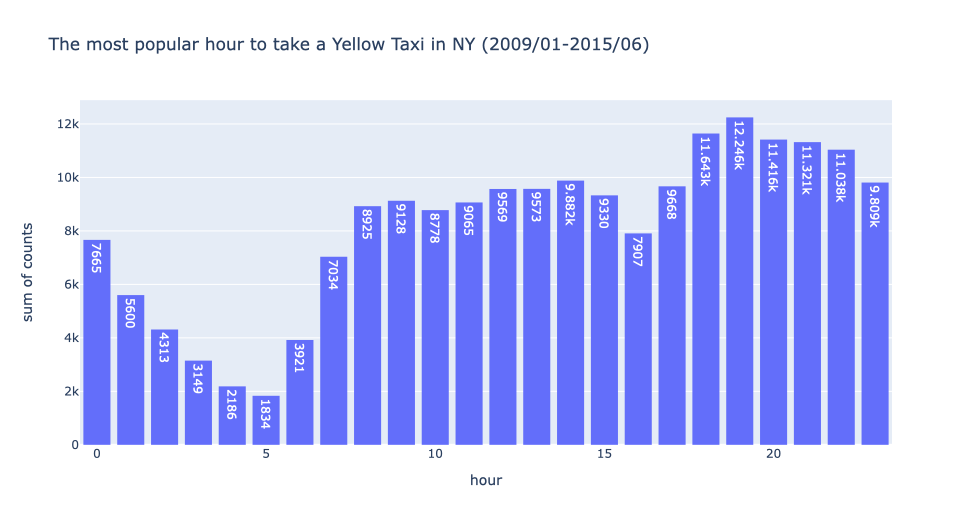

<IPython.core.display.Javascript object>

In [121]:
taxi_hour_df = get_popular_taxi_hour_df()
plot_popular_hour(taxi_hour_df)

# Fix the Ploty diagram not display in Github
if os.path.isfile(os.path.join(os.getcwd(), "plot1.png")):
    i = Image(filename="plot1.png")
    display(i)

### Visualization 2

Plot monthly average trip distance of Yellow taxi and Uber in NY from 2009/01 to 2015/06.

In [44]:
def plot_monthly_avg_distance(dataframe):
    """Plot diagram for monthly average trip distance of Yellow taxi and Uber in NY.

    Data from 01-2009 to 06-2015

    Args:
        dataframe (dataframe): dataframe to plot

    Returns:
        None

    """
    fig = px.scatter(
        dataframe,
        x="month",
        y="average distance",
        title="The average monthly trip distance of Yellow taxi and Uber in NY (2009/01-2015/06)",
    )
    fig.show("png")

<IPython.core.display.Javascript object>

In [45]:
def get_montly_trip_data():
    """Load taxi and uber data from database and clean the data.

    Args:
        None

    Returns:
        None

    """
    # Read taxi and Uber data
    df_t = pd.read_sql(
        "taxi_trips", con=engine, columns=["pickup_datetime", "distance"]
    )
    df_u = pd.read_sql(
        "uber_trips", con=engine, columns=["pickup_datetime", "distance"]
    )
    # Concat the dataframes
    df = pd.concat([df_t, df_u])

    # Group by month and caculate the average distance for each month
    df["month"] = df["pickup_datetime"].dt.month
    df = df.groupby(["month"])["distance"].mean().reset_index(name="average distance")

    return df

<IPython.core.display.Javascript object>

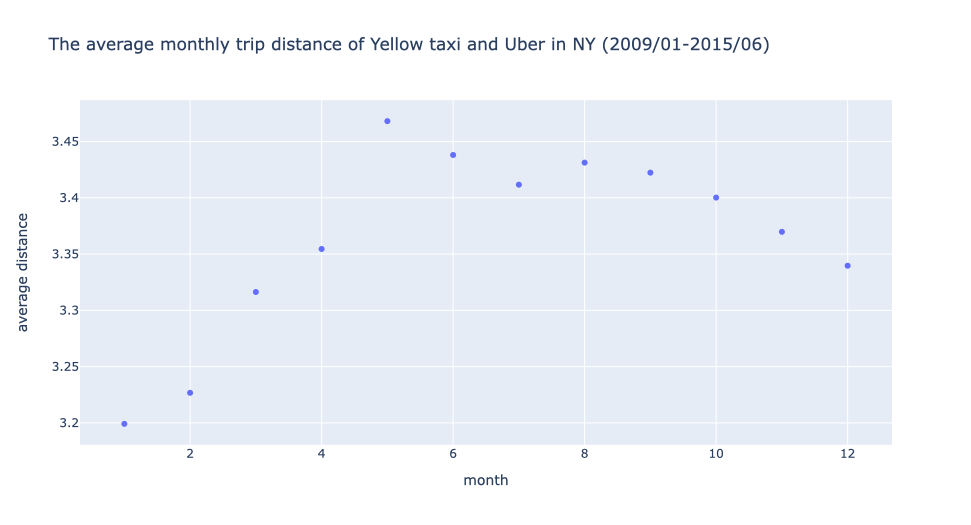

<IPython.core.display.Javascript object>

In [120]:
monthly_avg_distance_df = get_montly_trip_data()
plot_monthly_avg_distance(monthly_avg_distance_df)

# Fix the Ploty diagram not display in Github
if os.path.isfile(os.path.join(os.getcwd(), "plot2.png")):
    i = Image(filename="plot2.png")
    display(i)

### Visualization 3

Plot monthly average trip distance of Yellow taxi and Uber in NY from 2009/01 to 2015/06.

In [47]:
def plot_airports_dropoff(ewr_df, jfk_df, lga_df):
    """Plot monthly average trip distance of Yellow taxi and Uber in NY.

    Data from 01-2009 to 06-2015

    Args:
        ewr_df (dataframe): EWR data to plot
        jfk_df (dataframe): EWR data to plot
        lga_df (dataframe):EWR data to plot

    Returns:
        None

    """
    fig = go.Figure()
    fig.add_trace(go.Histogram(histfunc="count", x=ewr_df["day_of_week"], name="EWR"))
    fig.add_trace(go.Histogram(histfunc="count", x=jfk_df["day_of_week"], name="JFK"))
    fig.add_trace(go.Histogram(histfunc="count", x=lga_df["day_of_week"], name="LGA"))
    fig.update_layout(
        title="Number of dropoffs for day of week of the three airports in NY (EWR might be 0)",
        xaxis_title="day of week",
        yaxis_title="counts",
        legend_title="Airport",
    )

    fig.show()

<IPython.core.display.Javascript object>

In [48]:
# The bounding boxes for the three airports

lga_coord = (-73.889623, 40.764551, -73.853703, 40.787495)
jfk_coord = (-73.833618, 40.619425, -73.744011, 40.670353)
ewr_coord = (-74.200630, 40.667358, -74.147243, 40.713435)


def get_airports_dataframes():
    """Load taxi and uber data from database

    Clean the data for each airports.

    Args:
        None

    Returns:
        ewr_df (dataframe): dataframe for EWR airport
        jfk_df (dataframe): dataframe for JFK airport
        lga_df (dataframe): dataframe for LGA airport

    """
    # Read taxi and Uber data
    df_t = pd.read_sql(
        "taxi_trips",
        con=engine,
        columns=["pickup_datetime", "dropoff_latitude", "dropoff_longitude"],
    )
    df_u = pd.read_sql(
        "uber_trips",
        con=engine,
        columns=["pickup_datetime", "dropoff_latitude", "dropoff_longitude"],
    )
    # Concat the dataframes
    df = pd.concat([df_t, df_u])

    # Extract day of week for pickup time, as there's no dropoff time for Uber data
    df["day_of_week"] = df["pickup_datetime"].dt.day_name()
    df.drop(columns=["pickup_datetime"], inplace=True)

    ewr_df = get_single_airport_dataframe(df, ewr_coord)
    jfk_df = get_single_airport_dataframe(df, jfk_coord)
    lga_df = get_single_airport_dataframe(df, lga_coord)

    return ewr_df, jfk_df, lga_df


def get_single_airport_dataframe(df, airport_box_tuple):
    """Exract single airport dataframe

    Exract data for the three airports (EWR, JFK and LGA), into three separate
    dataframe.

    Args:
        df (dataframe): single dataframe for processing
        airport_box_tuple (tuple): airport box coordinates

    Returns:
        dataframe: signle airport dataframe

    """
    lon1, lat1, lon2, lat2 = airport_box_tuple

    df = df.drop(
        df[
            (df.dropoff_latitude > lat2)
            | (df.dropoff_latitude < lat1)
            | (df.dropoff_longitude > lon2)
            | (df.dropoff_longitude < lon1)
        ].index
    )
    df = df.sort_values(by="day_of_week")
    return df.reset_index(drop=True)

<IPython.core.display.Javascript object>

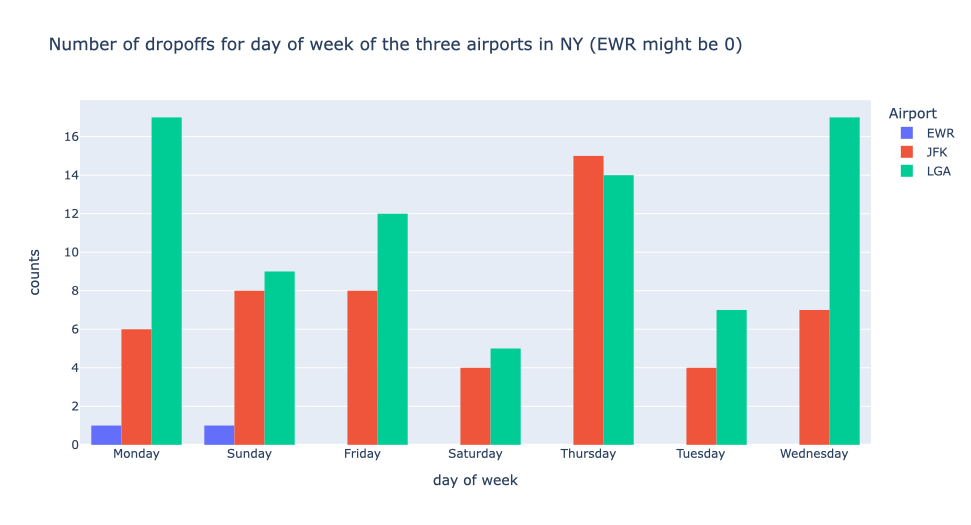

<IPython.core.display.Javascript object>

In [119]:
ewr_df, jfk_df, lga_df = get_airports_dataframes()
plot_airports_dropoff(ewr_df, jfk_df, lga_df)

# Fix the Ploty diagram not display in Github
if os.path.isfile(os.path.join(os.getcwd(), "plot3.png")):
    i = Image(filename="plot3.png")
    display(i)

### Visualization 4


### Visualization 5

Plot Yellow Taxi tip amount against the ride distance.

In [50]:
def plot_tip_vs_distance(taxi_tip_distance_df):
    """Plot Yellow Taxi tip amount against the ride distance in NY

    Data from 01-2009 to 06-2015.

    Args:
        taxi_tip_distance_df (dataframe): dataframe to plot

    Returns:
        None

    """
    fig = px.scatter(x=taxi_tip_distance_df.distance, y=taxi_tip_distance_df.tip_amount)
    fig.update_layout(
        title="Yellow Taxi Tip Amount vs. Distance",
        xaxis_title="distance (km)",
        yaxis_title="tip amount ($)",
    )

    fig.show()

<IPython.core.display.Javascript object>

In [56]:
def get_taxi_tip_distance_df():
    """Load taxi data from database and clean the data

    Keep only tip amount and distance columns, and remove the outliner.

    Args:
        None

    Returns:
        dataframe: cleaned taxi data

    """
    # Load df from database
    df = pd.read_sql(
        "taxi_trips",
        con=engine,
        columns=["distance", "tip_amount"],
    )

    # Remove tip_amount is 0
    df = df[(df["tip_amount"] != 0) & (df["tip_amount"] < 20) & (df["tip_amount"] > 1)]
    # Round value to 1
    df["tip_amount"] = df["tip_amount"].round(1)
    df["distance"] = df["distance"].round(1)
    df.reset_index(drop=True, inplace=True)
    return df

<IPython.core.display.Javascript object>

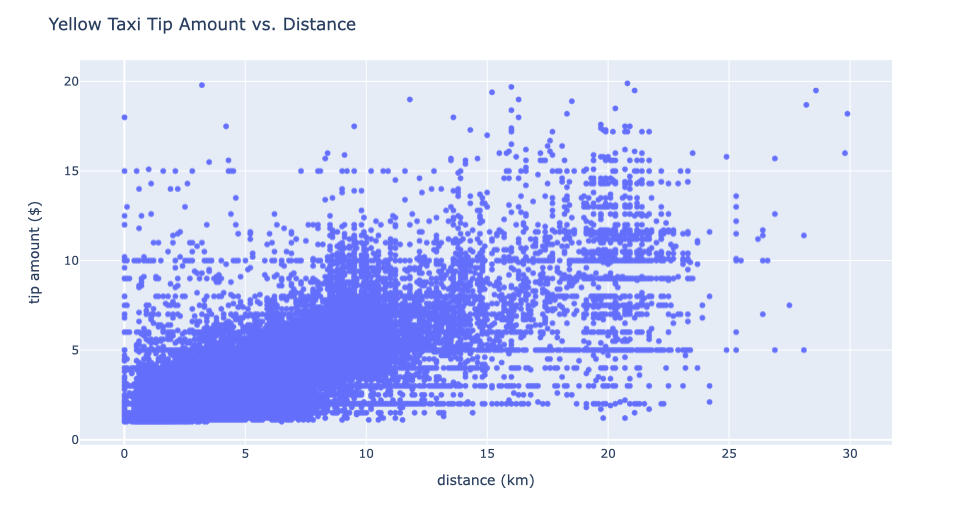

<IPython.core.display.Javascript object>

In [115]:
taxi_tip_distance_df = get_taxi_tip_distance_df()
plot_tip_vs_distance(taxi_tip_distance_df)

# Fix the Ploty diagram not display in Github
if os.path.isfile(os.path.join(os.getcwd(), "plot5.png")):
    i = Image(filename="plot5.png")
    display(i)

### Visualization 6

Plot Yellow Taxi tip amount against the precipitation amount when the ride is taken.

In [53]:
def plot_tip_vs_precipitation(df):
    """Plot Yellow Taxi tip amount against the precipitation amount.

    Data from 01-2009 to 06-2015, New York city.

    Args:
        df (dataframe): dataframe to plot

    Returns:
        None

    """
    fig = px.scatter(x=df.HourlyPrecipitation, y=df.tip_amount)
    fig.update_layout(
        title="Yellow Taxi Tip Amount vs. Precipitation",
        xaxis_title="Hourly Precipitation",
        yaxis_title="Tip Amount",
    )

    fig.show()

<IPython.core.display.Javascript object>

In [54]:
def get_tip_vs_precipitation_df():
    """Load and clean taxi and hourly weather data

    Load the data from database, keep need column,
    merge the dataframe and remove the outliner.

    Args:
        None

    Returns:
        dataframe: cleaned taxi data

    """
    # Load taxi data
    df_t = pd.read_sql(
        "taxi_trips",
        con=engine,
        columns=["pickup_datetime", "tip_amount"],
    )

    # Remove 0 tip
    df_t = df_t[(df_t["tip_amount"] != 0)]

    # load hourly weather data
    df_hw = pd.read_sql(
        "hourly_weather",
        con=engine,
        columns=["DATE", "HourlyPrecipitation"],
    )

    # Remove 0 tip and 0 Precipitation
    df_t = df_t[(df_t["tip_amount"] != 0) & (df_t["tip_amount"] < 15)]
    df_hw = df_hw[
        (df_hw["HourlyPrecipitation"] != 0) & (df_hw["HourlyPrecipitation"] > 0.2)
    ]

    # Round to Hour
    df_t = df_t.assign(pickup_datetime=df_t.pickup_datetime.dt.round("H"))
    df_hw = df_hw.assign(DATE=df_hw.DATE.dt.round("H"))

    # Normalize name
    df_t = df_t.rename(columns={"pickup_datetime": "DATE"})

    df = pd.merge(df_hw, df_t, on="DATE")

    return df

<IPython.core.display.Javascript object>

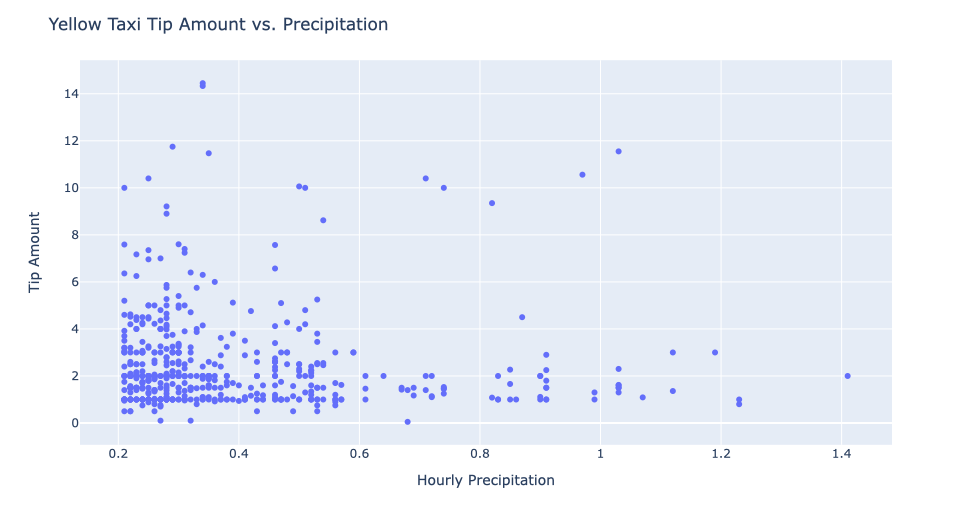

<IPython.core.display.Javascript object>

In [118]:
tip_vs_precipitation_df = get_tip_vs_precipitation_df()
plot_tip_vs_precipitation(tip_vs_precipitation_df)

# Fix the Ploty diagram not display in Github
if os.path.isfile(os.path.join(os.getcwd(), "plot6.png")):
    i = Image(filename="plot6.png")
    display(i)